In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import mne

# Load the raw data
raw = mne.io.read_raw_fif(r"C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\ICA\L\S001\sub-S001_L_eeg_raw.fif", preload=True)

# Filter out invalid annotations
annotations = raw.annotations
valid_descriptions = [ann for ann in annotations if ann['description'] not in ('side', 'event_timestamps', 'data_segments')]

# Create a new Annotations object with valid descriptions only
valid_annotations = mne.Annotations(
    onset=[ann['onset'] for ann in valid_descriptions],
    duration=[ann['duration'] for ann in valid_descriptions],
    description=[ann['description'] for ann in valid_descriptions],
    orig_time=annotations.orig_time
)

# Set the new annotations to raw
raw.set_annotations(valid_annotations)


Opening raw data file C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\ICA\L\S001\sub-S001_L_eeg_raw.fif...
    Range : 0 ... 46975 =      0.000 ...   183.507 secs
Ready.
Reading 0 ... 46975  =      0.000 ...   183.507 secs...


<Raw | sub-S001_L_eeg_raw.fif, 10 x 46976 (183.5 s), ~3.6 MB, data loaded>

In [2]:
import numpy as np
import mne
from scipy import signal
from scipy.signal import butter, filtfilt, iirnotch, detrend
from definitions import CHAN_LOC
import pyxdf  # For loading .xdf files
import matplotlib.pyplot as plt
import os
import re

In [3]:
def load_xdf_file(filepath):
    """Load the XDF file using pyxdf."""
    streams, header = pyxdf.load_xdf(filepath)
    return streams, header

In [4]:
def find_xdf_files(base_dir):
    """
    Find all .xdf files within the given directory and its subdirectories.

    Parameters:
    base_dir : str
        The base directory to start the search from.

    Returns:
    file_paths : list
        List of paths to .xdf files.
    """
    file_paths = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".xdf"):
                file_paths.append(os.path.join(root, file))
    return file_paths

In [5]:
def process_all_xdf_files(base_dir, base_save_dir):
    """
    Process all .xdf files in the LEFT and RIGHT directories by applying perform_ICA.

    Parameters:
    base_dir : str
        The base directory containing the LEFT and RIGHT folders.
    """
    left_dir = os.path.join(base_dir, 'LEFT')
    right_dir = os.path.join(base_dir, 'RIGHT')

    # Find all .xdf files in the LEFT and RIGHT directories
    left_files = find_xdf_files(left_dir)
    right_files = find_xdf_files(right_dir)

    print(f"Found {len(left_files)} files in LEFT directory.")
    print(f"Found {len(right_files)} files in RIGHT directory.")

    # Process LEFT files (side_identifier = 1)
    for left_file in left_files:
        print(f"Processing {left_file}...")
        streams_L, header_L = load_xdf_file(left_file)
        try:
            EEG_DATA_L, ICA_L = perform_ICA(streams_L, 1, left_file,base_save_dir )
        except Exception as e:
            print(f"Error processing {left_file}: {e}")

    # Process RIGHT files (side_identifier = 2)
    for right_file in right_files:
        print(f"Processing {right_file}...")
        streams_R, header_R = load_xdf_file(right_file)
        try:
            EEG_DATA_R, ICA_R = perform_ICA(streams_R, 2, right_file,base_save_dir)
        except Exception as e:
            print(f"Error processing {right_file}: {e}")

In [6]:
import os
import re
import numpy as np
import mne

def perform_ICA(streams, side_identifier, xdf_filename, base_save_dir, trim_samples=(0, 0)):
    """
    Perform ICA on EEG data and save the ICA solution and filtered raw EEG data with unique filenames.

    Parameters:
    streams : list
        List containing the EEG data (as dictionaries).
    side_identifier : int
        1 for Left (L) side, 2 for Right (R) side, used to differentiate the filenames.
    xdf_filename : str
        The original filename of the .xdf file to extract subject and session info from.
    base_save_dir : str
        The base directory where the processed data should be saved.
    trim_samples : tuple
        Tuple containing the number of samples to trim from the beginning and the end.

    Returns:
    raw : mne.io.Raw
        The raw EEG data after preprocessing.
    ica : mne.preprocessing.ICA
        The fitted ICA solution.
    timestamps : np.ndarray
        The relevant time stamps from the streams.
    relevant_time_series : np.ndarray
        The time series corresponding to the relevant time stamps.
    """
    # Check the structure of the streams
    print(f"Length of the streams list: {len(streams)}")

    # Initialize variables
    data = None
    sampling_rate = None
    timestamps = None

    # Use the second stream if it has 10 channels and valid sampling rate
    first_stream_data = np.array(streams[0]['time_series'])
    second_stream_data = np.array(streams[1]['time_series']) if len(streams) > 1 else None

    if second_stream_data is not None and second_stream_data.shape[1] == 10 and streams[1]['info']['effective_srate'] > 0:
        data = second_stream_data
        sampling_rate = streams[1]['info']['effective_srate']
        timestamps = np.array(streams[1]['time_stamps'])
        print("Using second stream with shape:", data.shape)
    else:
        raise ValueError("No valid data found in the streams.")

    # Ensure valid numeric data
    if not isinstance(data, np.ndarray) or not np.issubdtype(data.dtype, np.number):
        raise ValueError("No valid numeric data found in any of the streams.")

    # Trim the data and timestamps
    if trim_samples[0] > 0 or trim_samples[1] > 0:
        # Ensure we don't trim more than available
        trim_start = min(trim_samples[0], data.shape[0])
        trim_end = min(trim_samples[1], data.shape[0])
        
        # Trim the data
        data = data[trim_start:data.shape[0] - trim_end]
        
        # Trim the timestamps as well
        if timestamps is not None:
            timestamps = timestamps[trim_start:len(timestamps) - trim_end]

    # Create a RawArray object for MNE
    ch_names = ['F3', 'Fz', 'F4', 'C3', 'Cz', 'C4', 'P3', 'Pz', 'P4', 'GND']
    info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types='eeg')

    raw = mne.io.RawArray(data.T, info)  # Transpose data to fit MNE format (channels x samples)

    # Set montage
    montage = mne.channels.make_dig_montage(ch_pos={
        'F3': (-39, 0.33333, 0), 
        'Fz': (0, 0.25556, 0),
        'F4': (39, 0.33333, 0),
        'C3': (-90, 0.25556, 0),
        'Cz': (90, 0, 0),
        'C4': (90, 0.25556, 0),
        'P3': (-141, 0.33333, 0),
        'Pz': (180, 0.25556, 0),
        'P4': (141, 0.33333, 0),
        'GND': (-162, 0.51111, 0)
    })
    raw.set_montage(montage)

    # High-pass filter the data
    raw.filter(l_freq=1.0, h_freq=30)

    # Perform ICA
    n_channels = data.shape[1]
    ica = mne.preprocessing.ICA(n_components=n_channels, random_state=97, max_iter=800)
    ica.fit(raw)

    # Extract subject and session info from xdf_filename
    match = re.search(r'sub-(P\d+)_ses-(S\d+)', xdf_filename)
    if match:
        subject_id = match.group(1)
        session_id = match.group(2)
    else:
        raise ValueError("Invalid XDF filename format. Could not extract subject and session IDs.")

    # Determine side label (L or R)
    side_label = 'L' if side_identifier == 1 else 'R'

    # Create dynamic save directory based on the side, subject, and session
    save_dir = os.path.join(base_save_dir, side_label, f"sub-{subject_id}", f"ses-{session_id}")
    os.makedirs(save_dir, exist_ok=True)

    # Save the ICA solution
    ica_filename = os.path.join(save_dir, f"SUB2_ses_{session_id}_{side_label}_ica.fif")
    try:
        ica.save(ica_filename)
        print(f"ICA solution saved to {ica_filename}")
    except Exception as e:
        print(f"Error saving ICA solution: {e}")

    # Save the raw EEG data
    raw_filename = os.path.join(save_dir, f"SUB2_ses_{session_id}_{side_label}_raw.fif")
    try:
        raw.save(raw_filename, overwrite=True)
        print(f"Raw EEG data saved to {raw_filename}")
    except Exception as e:
        print(f"Error saving raw EEG data: {e}")

    # Return the raw object, ICA object, timestamps, and relevant time series data
    relevant_time_series = data.shape[0]
    return raw, ica, timestamps, relevant_time_series


In [7]:
def filtering(EEG_data):
    # Sampling rate
    sampling_rate = EEG_data.info['sfreq']

    # Butterworth bandpass filter between 0.3 and 10 Hz (4th order)
    b_butter, a_butter = butter(4, [0.3, 10], btype='bandpass', fs=sampling_rate)

    # Mu wave frequency range
    mu_range = [8, 12]
    b_mu, a_mu = butter(4, mu_range, btype='bandpass', fs=sampling_rate)

    # Notch filter for power line noise at 50 Hz
    b_notch, a_notch = iirnotch(50, 50 / 35, sampling_rate)

    # Initialize the filtered data
    eeg_data_notch = np.zeros_like(EEG_data.get_data())
    eeg_data_but = np.zeros_like(EEG_data.get_data())
    eeg_data_mu = np.zeros_like(EEG_data.get_data())
    eeg_data_mean = np.zeros_like(EEG_data.get_data())

    # Apply filtering to each channel
    for i in range(EEG_data.get_data().shape[0]):
        # Apply notch filter to remove 50 Hz power line noise
        eeg_data_notch[i, :] = filtfilt(b_notch, a_notch, EEG_data.get_data()[i, :])

        # Apply Butterworth bandpass filter (0.3-10 Hz)
        eeg_data_but[i, :] = filtfilt(b_butter, a_butter, detrend(eeg_data_notch[i, :]))

        # Apply Butterworth filter for mu waves (8-12 Hz)
        eeg_data_mu[i, :] = filtfilt(b_mu, a_mu, detrend(eeg_data_but[i, :]))

        # Calculate the mean for each channel after mu wave filtering
        eeg_data_mean[i, :] = np.mean(eeg_data_mu[i, :])

    # Transpose the filtered data
    eeg_data_but = eeg_data_but.T

    # Zero-mean the data
    channels_mean = np.mean(eeg_data_but, axis=1)
    channels_mean_matrix = np.tile(channels_mean[:, np.newaxis], (1, eeg_data_but.shape[1]))
    EEG_filt = eeg_data_but - channels_mean_matrix

    return EEG_filt

In [8]:
def plot_eeg(EEG_filt, events, sampling_rate, title):
    """ Plot EEG data with event markers. """
    time_vector = np.arange(len(EEG_filt)) / sampling_rate
    plt.figure()
    plt.plot(time_vector, EEG_filt[:, 5])  # Cz channel (index 5)
    plt.xlabel('Time (s)')
    plt.ylabel('EEG Data')
    plt.title(title)
    for event in events:
        plt.axvline(x=event / sampling_rate, color='r', linestyle='--')
    plt.show()

In [9]:
def plot_topoplot(mean_data, title):
    """ Plot the topographic map (topoplot) of EEG data. """
    mne.viz.plot_topomap(mean_data, pos=CHAN_LOC, show=True)
    plt.title(title)
    plt.show()


In [10]:
# Load XDF files

# Specify the base directory (where SUB_2 is located)
base_dir = r"C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2"

base_save_dir = r"C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED"

# Process all XDF files in the LEFT and RIGHT directories
process_all_xdf_files(base_dir,base_save_dir)

Found 10 files in LEFT directory.
Found 11 files in RIGHT directory.
Processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-Default_run-001_eeg.xdf...
Length of the streams list: 2
Using second stream with shape: (46976, 10)
Creating RawArray with float64 data, n_channels=10, n_times=46976
    Range : 0 ... 46975 =      0.000 ...   183.507 secs
Ready.


C:\Users\Ferran\AppData\Local\Temp\ipykernel_16572\3962566961.py:88: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 11.7s.
Error saving ICA solution: Destination file exists. Please use option "overwrite=True" to force overwriting.
Overwriting existing file.
Writing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S001\SUB2_ses_S001_L_raw.fif
Closing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA

C:\Users\Ferran\anaconda3\envs\TFM\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Raw EEG data saved to C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S001\SUB2_ses_S001_L_raw.fif
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-Default_run-001_eeg.xdf: too many values to unpack (expected 2)
Processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S002\eeg\sub-P001_ses-S002_task-Default_run-001_eeg.xdf...
Length of the streams list: 2
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S002\eeg\sub-P001_ses-S002_task-Default_run-001_eeg.xdf: No valid data found in the streams.
Processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S003\eeg\sub-P001_ses-S003_task-Default_run-001_eeg.xdf...
Length of the streams list: 2
Using second stream with shape: (55808, 10)
Creating RawArray with float64 data, n_channels=10, n_times=55808
    Range : 0 ... 55807 =      0.000 ...   218.009 secs
Read

C:\Users\Ferran\AppData\Local\Temp\ipykernel_16572\3962566961.py:88: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Fitting ICA took 0.6s.
Error saving ICA solution: Destination file exists. Please use option "overwrite=True" to force overwriting.
Overwriting existing file.
Writing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S003\SUB2_ses_S003_L_raw.fif
Closing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S003\SUB2_ses_S003_L_raw.fif
[done]
Raw EEG data saved to C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S003\SUB2_ses_S003_L_raw.fif
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S003\eeg\sub-P001_ses-S003_task-Default_run-001_eeg.xdf: too many values to unpack (expected 2)
Processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S004\eeg\sub-P001_ses-S004_task-Default_run-001_eeg.xdf...
Length of the streams list: 2
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S004\eeg\sub-P001_ses-S004_task-Default_run-001_ee

C:\Users\Ferran\AppData\Local\Temp\ipykernel_16572\3962566961.py:88: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Fitting ICA took 0.4s.
Error saving ICA solution: Destination file exists. Please use option "overwrite=True" to force overwriting.
Overwriting existing file.
Writing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S005\SUB2_ses_S005_L_raw.fif
Closing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S005\SUB2_ses_S005_L_raw.fif
[done]
Raw EEG data saved to C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S005\SUB2_ses_S005_L_raw.fif
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S005\eeg\sub-P001_ses-S005_task-Default_run-001_eeg.xdf: too many values to unpack (expected 2)
Processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S006\eeg\sub-P001_ses-S006_task-Default_run-001_eeg.xdf...
Length of the streams list: 2
Using second stream with shape: (55944, 10)
Creating RawArray with float64 data, n_channels=10, n_times=55944
    Range : 0 ... 55943 =   

C:\Users\Ferran\AppData\Local\Temp\ipykernel_16572\3962566961.py:88: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Fitting ICA took 0.2s.
Error saving ICA solution: Destination file exists. Please use option "overwrite=True" to force overwriting.
Overwriting existing file.
Writing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S006\SUB2_ses_S006_L_raw.fif
Closing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S006\SUB2_ses_S006_L_raw.fif
[done]
Raw EEG data saved to C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S006\SUB2_ses_S006_L_raw.fif
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S006\eeg\sub-P001_ses-S006_task-Default_run-001_eeg.xdf: too many values to unpack (expected 2)
Processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S007\eeg\sub-P001_ses-S007_task-Default_run-001_eeg.xdf...
Length of the streams list: 2
Using second stream with shape: (43520, 10)
Creating RawArray with float64 data, n_channels=10, n_times=43520
    Range : 0 ... 43519 =   

C:\Users\Ferran\AppData\Local\Temp\ipykernel_16572\3962566961.py:88: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Fitting ICA took 0.5s.
Error saving ICA solution: Destination file exists. Please use option "overwrite=True" to force overwriting.
Overwriting existing file.
Writing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S007\SUB2_ses_S007_L_raw.fif
Closing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S007\SUB2_ses_S007_L_raw.fif
[done]
Raw EEG data saved to C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S007\SUB2_ses_S007_L_raw.fif
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S007\eeg\sub-P001_ses-S007_task-Default_run-001_eeg.xdf: too many values to unpack (expected 2)
Processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S008\eeg\sub-P001_ses-S008_task-Default_run-001_eeg.xdf...
Length of the streams list: 2
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S008\eeg\sub-P001_ses-S008_task-Default_run-001_ee

C:\Users\Ferran\AppData\Local\Temp\ipykernel_16572\3962566961.py:88: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Fitting ICA took 0.5s.
Error saving ICA solution: Destination file exists. Please use option "overwrite=True" to force overwriting.
Overwriting existing file.
Writing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S009\SUB2_ses_S009_L_raw.fif
Closing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S009\SUB2_ses_S009_L_raw.fif
[done]
Raw EEG data saved to C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S009\SUB2_ses_S009_L_raw.fif
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S009\eeg\sub-P001_ses-S009_task-Default_run-001_eeg.xdf: too many values to unpack (expected 2)
Processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S010\eeg\sub-P001_ses-S010_task-Default_run-001_eeg.xdf...
Length of the streams list: 2
Using second stream with shape: (43136, 10)
Creating RawArray with float64 data, n_channels=10, n_times=43136
    Range : 0 ... 43135 =   

C:\Users\Ferran\AppData\Local\Temp\ipykernel_16572\3962566961.py:88: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Fitting ICA took 0.2s.
Error saving ICA solution: Destination file exists. Please use option "overwrite=True" to force overwriting.
Overwriting existing file.
Writing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S010\SUB2_ses_S010_L_raw.fif
Closing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S010\SUB2_ses_S010_L_raw.fif
[done]
Raw EEG data saved to C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\L\sub-P001\ses-S010\SUB2_ses_S010_L_raw.fif
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\LEFT\sub-P001\ses-S010\eeg\sub-P001_ses-S010_task-Default_run-001_eeg.xdf: too many values to unpack (expected 2)
Processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RIGHT\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-Default_run-001_eeg.xdf...
Length of the streams list: 2
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RIGHT\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-Default_run-001_

C:\Users\Ferran\AppData\Local\Temp\ipykernel_16572\3962566961.py:88: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Fitting ICA took 11.7s.
Error saving ICA solution: Destination file exists. Please use option "overwrite=True" to force overwriting.
Overwriting existing file.
Writing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S001\SUB2_ses_S001_R_raw.fif
Closing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S001\SUB2_ses_S001_R_raw.fif
[done]


C:\Users\Ferran\anaconda3\envs\TFM\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Raw EEG data saved to C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S001\SUB2_ses_S001_R_raw.fif
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RIGHT\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-Default_run-001_eeg_old1.xdf: too many values to unpack (expected 2)
Processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RIGHT\sub-P001\ses-S002\eeg\sub-P001_ses-S002_task-Default_run-001_eeg.xdf...
Length of the streams list: 2
Using second stream with shape: (47104, 10)
Creating RawArray with float64 data, n_channels=10, n_times=47104
    Range : 0 ... 47103 =      0.000 ...   184.007 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00

C:\Users\Ferran\AppData\Local\Temp\ipykernel_16572\3962566961.py:88: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Fitting ICA took 11.1s.
Error saving ICA solution: Destination file exists. Please use option "overwrite=True" to force overwriting.
Overwriting existing file.
Writing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S002\SUB2_ses_S002_R_raw.fif
Closing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S002\SUB2_ses_S002_R_raw.fif
[done]


C:\Users\Ferran\anaconda3\envs\TFM\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Raw EEG data saved to C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S002\SUB2_ses_S002_R_raw.fif
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RIGHT\sub-P001\ses-S002\eeg\sub-P001_ses-S002_task-Default_run-001_eeg.xdf: too many values to unpack (expected 2)
Processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RIGHT\sub-P001\ses-S003\eeg\sub-P001_ses-S003_task-Default_run-001_eeg.xdf...
Length of the streams list: 2
Using second stream with shape: (47232, 10)
Creating RawArray with float64 data, n_channels=10, n_times=47232
    Range : 0 ... 47231 =      0.000 ...   184.507 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lo

C:\Users\Ferran\AppData\Local\Temp\ipykernel_16572\3962566961.py:88: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Fitting ICA took 1.2s.
Error saving ICA solution: Destination file exists. Please use option "overwrite=True" to force overwriting.
Overwriting existing file.
Writing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S003\SUB2_ses_S003_R_raw.fif
Closing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S003\SUB2_ses_S003_R_raw.fif
[done]
Raw EEG data saved to C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S003\SUB2_ses_S003_R_raw.fif
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RIGHT\sub-P001\ses-S003\eeg\sub-P001_ses-S003_task-Default_run-001_eeg.xdf: too many values to unpack (expected 2)
Processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RIGHT\sub-P001\ses-S004\eeg\sub-P001_ses-S004_task-Default_run-002_eeg.xdf...
Length of the streams list: 2
Using second stream with shape: (43648, 10)
Creating RawArray with float64 data, n_channels=10, n_times=43648
    Range : 0 ... 43647 = 

C:\Users\Ferran\AppData\Local\Temp\ipykernel_16572\3962566961.py:88: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Fitting ICA took 11.5s.
Error saving ICA solution: Destination file exists. Please use option "overwrite=True" to force overwriting.
Overwriting existing file.
Writing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S004\SUB2_ses_S004_R_raw.fif
Closing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S004\SUB2_ses_S004_R_raw.fif
[done]


C:\Users\Ferran\anaconda3\envs\TFM\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Raw EEG data saved to C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S004\SUB2_ses_S004_R_raw.fif
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RIGHT\sub-P001\ses-S004\eeg\sub-P001_ses-S004_task-Default_run-002_eeg.xdf: too many values to unpack (expected 2)
Processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RIGHT\sub-P001\ses-S005\eeg\sub-P001_ses-S005_task-Default_run-001_eeg.xdf...
Length of the streams list: 2
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RIGHT\sub-P001\ses-S005\eeg\sub-P001_ses-S005_task-Default_run-001_eeg.xdf: No valid data found in the streams.
Processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RIGHT\sub-P001\ses-S006\eeg\sub-P001_ses-S006_task-Default_run-001_eeg.xdf...
Length of the streams list: 2
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RIGHT\sub-P001\ses-S006\eeg\sub-P001_ses-S006_task-Default_run-001_eeg.xdf: No valid data found 

C:\Users\Ferran\AppData\Local\Temp\ipykernel_16572\3962566961.py:88: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Fitting ICA took 0.2s.
Error saving ICA solution: Destination file exists. Please use option "overwrite=True" to force overwriting.
Overwriting existing file.
Writing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S009\SUB2_ses_S009_R_raw.fif
Closing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S009\SUB2_ses_S009_R_raw.fif
[done]
Raw EEG data saved to C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S009\SUB2_ses_S009_R_raw.fif
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RIGHT\sub-P001\ses-S009\eeg\sub-P001_ses-S009_task-Default_run-001_eeg.xdf: too many values to unpack (expected 2)
Processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RIGHT\sub-P001\ses-S010\eeg\sub-P001_ses-S010_task-Default_run-001_eeg.xdf...
Length of the streams list: 2
Using second stream with shape: (43648, 10)
Creating RawArray with float64 data, n_channels=10, n_times=43648
    Range : 0 ... 43647 = 

C:\Users\Ferran\AppData\Local\Temp\ipykernel_16572\3962566961.py:88: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Fitting ICA took 0.4s.
Error saving ICA solution: Destination file exists. Please use option "overwrite=True" to force overwriting.
Overwriting existing file.
Writing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S010\SUB2_ses_S010_R_raw.fif
Closing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S010\SUB2_ses_S010_R_raw.fif
[done]
Raw EEG data saved to C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S010\SUB2_ses_S010_R_raw.fif
Error processing C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RIGHT\sub-P001\ses-S010\eeg\sub-P001_ses-S010_task-Default_run-001_eeg.xdf: too many values to unpack (expected 2)


In [11]:
# import matplotlib.pyplot as plt

# # Plot the raw EEG data for the right side (EEG_DATA_R)
# EEG_DATA_R.plot(title="Right Side - Raw EEG Data", show=True)

# # Plot the raw EEG data for the left side (EEG_DATA_L)
# EEG_DATA_L.plot(title="Left Side - Raw EEG Data", show=True)

# # Plot the ICA components for the right side (ICA_R)
# ICA_R.plot_components(title="Right Side - ICA Components", show=True)

# # Plot the ICA components for the left side (ICA_L)
# ICA_L.plot_components(title="Left Side - ICA Components", show=True)

# # Plot the ICA sources (after applying the ICA solution to the raw data)
# ICA_R.plot_sources(EEG_DATA_R, title="Right Side - ICA Sources", show=True)
# ICA_L.plot_sources(EEG_DATA_L, title="Left Side - ICA Sources", show=True)


In [12]:
raw = mne.io.read_raw_fif(r"C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S001\SUB2_ses_S001_R_raw.fif" , preload=True)
data, times = raw[:]
print(f"Max value in data: {data.max()}")

raw.apply_function(lambda x: x * 1e6, picks='eeg')  # Convert from volts to microvolts

# Get the data and check its shape
data, times = raw.get_data(return_times=True)
print(f"Data shape: {data.shape}")  # (n_channels, n_times)
print(f"First 10 samples from each channel:\n {data[:, :10]}")  # Check the first 10 samples for each channel

raw.plot(scalings='auto')  # Adjust scaling if needed, or try a custom scaling like 'eeg': 20e-6


Opening raw data file C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S001\SUB2_ses_S001_R_raw.fif...
    Range : 0 ... 47231 =      0.000 ...   184.506 secs
Ready.
Reading 0 ... 47231  =      0.000 ...   184.506 secs...
Max value in data: 97.39339447021484
Data shape: (10, 47232)
First 10 samples from each channel:
 [[-1.29674049e-06 -4.12409163e+06 -7.42138767e+06 -9.37338352e+06
  -9.95874310e+06 -9.61475754e+06 -8.99635124e+06 -8.66994572e+06
  -8.88089275e+06 -9.49674511e+06]
 [-9.30810984e-07 -2.56761765e+06 -5.11219645e+06 -7.53204203e+06
  -9.64367771e+06 -1.12469902e+07 -1.22170191e+07 -1.25866241e+07
  -1.25524616e+07 -1.23905687e+07]
 [-3.26849658e-07  1.23265636e+06  1.72944939e+06  1.08087921e+06
  -6.42196834e+05 -2.92130065e+06 -4.99647045e+06 -6.19864273e+06
  -6.22684479e+06 -5.23942280e+06]
 [-2.77111667e-07 -4.16261721e+06 -7.79454851e+06 -1.04794207e+07
  -1.20199366e+07 -1.24899597e+07 -1.22057209e+07 -1.16274538e+07
  -1.12058048e+07 -1.121

Reading C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S001\SUB2_ses_S001_R_ica.fif ...
Now restoring ICA solution ...
Ready.


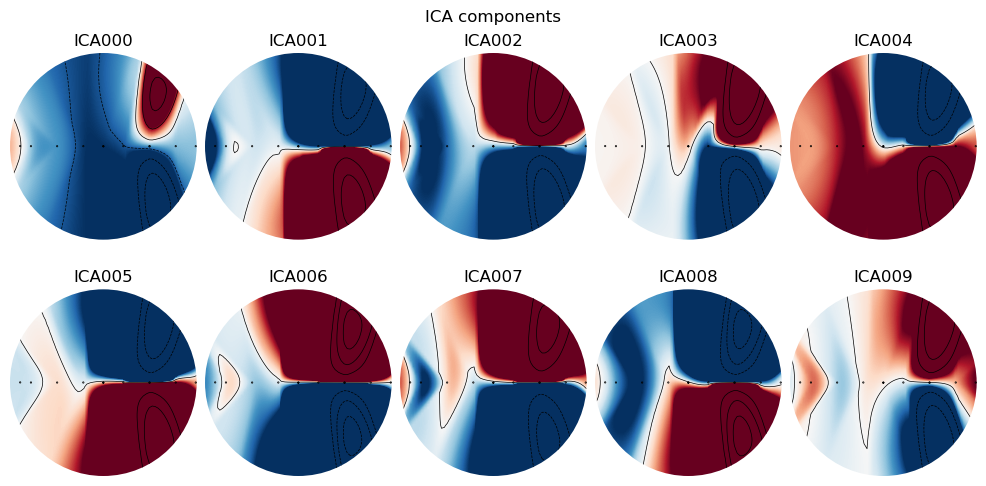

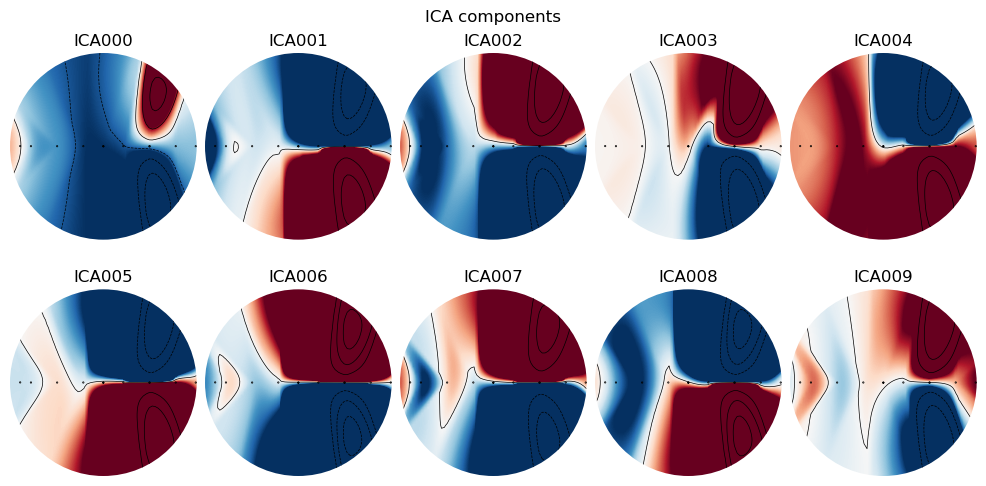

In [13]:
ica = mne.preprocessing.read_ica(r"C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S001\SUB2_ses_S001_R_ica.fif")
ica.plot_components()  # Visualize ICA components to identify artifacts

In [14]:
# Remove unwanted components (e.g., eye blinks):
ica.exclude = [0, 1]  # Exclude components that represent artifacts (e.g., components 0 and 1)
ica.apply(raw)  # Apply ICA to the raw data to remove artifacts

raw.plot()  # Now, you should see cleaner EEG data with artifacts removed



Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 10 PCA components


In [15]:
import mne

# Specify the path to your .fif file
fif_file_path = r"C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S001\SUB2_ses_S001_R_raw.fif"  # Replace with your actual file path

# Load the FIF file
raw = mne.io.read_raw_fif(fif_file_path, preload=True)

# Print information about the raw data
print(raw.info)

# Optionally, plot the data
raw.plot()


Opening raw data file C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\ICA_FILTERED\R\sub-P001\ses-S001\SUB2_ses_S001_R_raw.fif...
    Range : 0 ... 47231 =      0.000 ...   184.506 secs
Ready.
Reading 0 ... 47231  =      0.000 ...   184.506 secs...
<Info | 10 non-empty values
 bads: []
 ch_names: F3, Fz, F4, C3, Cz, C4, P3, Pz, P4, GND
 chs: 10 EEG
 custom_ref_applied: False
 dig: 13 items (3 Cardinal, 10 EEG)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 10
 projs: []
 sfreq: 256.0 Hz
>


In [16]:
# Filter EEG data
EEG_filt_R = filtering(EEG_DATA_R)
EEG_filt_L = filtering(EEG_DATA_L)

# Plot EEG Data with Event Markers
sampling_rate = EEG_DATA_R.info['sfreq']
events_right = streams_R[0]['time_stamps'] * sampling_rate
events_left = streams_L[0]['time_stamps'] * sampling_rate

plot_eeg(EEG_filt_R, events_right, sampling_rate, 'EEG Data with Event Markers (Right)')
plot_eeg(EEG_filt_L, events_left, sampling_rate, 'EEG Data with Event Markers (Left)')

# Create and plot Topoplots
mean_R_data = np.mean(EEG_filt_R, axis=0)
mean_L_data = np.mean(EEG_filt_L, axis=0)

plot_topoplot(mean_R_data, 'EEG TOPOPLOT for Right Events')
plot_topoplot(mean_L_data, 'EEG TOPOPLOT for Left Events')

NameError: name 'EEG_DATA_R' is not defined

In [ ]:
# def perform_ICA(streams):
#     if streams['time_series'].shape
#         # Attempt to load EEG data from the primary stream
#         data = streams[0]['time_series'][:,:9]
#         sampling_rate = streams[0]['info']['effective_srate']
#     except Exception as e:
#         print(f"Primary stream loading failed: {e}. Trying secondary stream...")
#         # Load EEG data from the alternative stream if the first attempt fails
#         data = streams[1]['time_series'][:9, :]
#         sampling_rate = streams[1]['info']['effective_srate']

#     # Load your channel locations file
#     chanlocs = r"C:\Users\Ferran\Desktop\TFM\TFM_EEG\Documents\Standard-10-20-Cap10.txt"

#     # Create an MNE RawArray object from the data
#     num_channels = data.shape[0]
#     ch_names = ['EEG' + str(i) for i in range(1, num_channels + 1)]  # Assuming generic channel names
#     montage = mne.channels.read_custom_montage(chanlocs)  # Load channel locations
#     info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types='eeg')
#     raw = mne.io.RawArray(data, info)
#     raw.set_montage(montage)
    
#     # Preprocess the data (bandpass filter between 1-50 Hz)
#     raw.filter(1., 50., fir_design='firwin')
    
#     # Run ICA
#     ica = mne.preprocessing.ICA(n_components=num_channels, method='fastica', random_state=97)
#     ica.fit(raw)
    
#     # Optional: Save the ICA results
#     ica.save('yourdata_ica.fif')  # Uncomment and modify the path to save the ICA
    
#     return raw, ica
